<a href="https://colab.research.google.com/github/astro-informatics/harmonic/blob/main/notebooks/cross_validation_hyper_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://raw.githubusercontent.com/astro-informatics/harmonic/fa99200ddd9c942921439cfbadf30c6ede7226f3/docs/assets/harm_badge_simple.svg" width="250" height="250"/>

# [`harmonic`](https://github.com/astro-informatics/harmonic) - __Hyper-parameter Cross-validation__ Interactive Tutorial
---


In this interactive tutorial we continue to demonstrate basic usage of `harmonic` applied to the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), using [`emcee`](https://emcee.readthedocs.io/en/stable/) as the sampler.

This tutorial is very similar to the *basic usage* tutorial but here we use `harmonic`'s cross-validation functionality to select the hyper-parameters of the machine learning model used.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    # Install packages
    %pip install harmonic emcee corner getdist
    # Google Colaboratory-specific: clone useful utils module from harmonic repo
    !git clone https://github.com/astro-informatics/harmonic.git
    import sys
    sys.path.append("harmonic/examples")

In [2]:
%%capture
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import harmonic as hm
from functools import partial
import emcee
import harmonic.utils as utils

# Define Bayesian posterior function 
---

Now we will need to define the log-posterior function of interest. 

As a working example for this tutorial we consider a likelihood given by the Rosenbrock function

$$
f(x) = \sum_{i=1}^{d-1} \bigg [ b(x_{i+1} - x_{i}^2)^2 + (x_i - a)^2 \bigg ]
$$

where $d$ is the dimension of the function and the input domain is usually taken to be $x_i \in [-5.0, 10.0], \: \; \forall i = 1, \dots, d$.  The Rosenbrock function is a common benchmark example since it is known to be a difficult project due to the shallow curving degenercy.  The likelihood is then implemented as follows.  For the hyper-parameters we adopt the common values $a=1.0$ and $b=100.0$.

In [3]:
def ln_likelihood(x, a=1.0, b=100.0):
    """Compute log_e of likelihood defined by Rosenbrock function.
    
    Args: 
    
        x: Position at which to evaluate likelihood.
        
        a: First parameter of Rosenbrock function. 
        
        b: First parameter of Rosenbrock function. 
        
    Returns:
    
        double: Value of Rosenbrock at specified point.
        
    """
    
    ndim = x.size

    f = 0.0

    for i_dim in range(ndim-1):
        f += b*(x[i_dim+1]-x[i_dim]**2)**2 + (a-x[i_dim])**2

    return -f

We adopt a uniform prior over the parameter support $x_i \in [-5.0, 10.0]$, which is implemented as follows.

In [4]:
def ln_prior_uniform(x, xmin=-10.0, xmax=10.0, ymin=-5.0, ymax=15.0):
    """Compute log_e of uniform prior.
    
    Args: 
    
        x: Position at which to evaluate prior.
        
        xmin: Uniform prior minimum x edge (first dimension).
        
        xmax: Uniform prior maximum x edge (first dimension).
        
        ymin: Uniform prior minimum y edge (second dimension).
        
        ymax: Uniform prior maximum y edge (second dimension).
        
    Returns:
    
        double: Value of prior at specified point.
        
    """
        
    if x[0] >= xmin and x[0] <= xmax and x[1] >= ymin and x[1] <= ymax:        
        return 1.0 / ( (xmax - xmin) * (ymax - ymin) )
    else:
        return 0.0

The likelihood and prior are combined to form the log posterior function as follows.


In [5]:
def ln_posterior(x, ln_prior, a=1.0, b=100.0):
    """Compute log_e of posterior.
    
    Args: 
    
        x: Position at which to evaluate posterior.
        
        a: First parameter of Rosenbrock function.
        
        b: First parameter of Rosenbrock function.
        
        ln_prior: Prior function.
        
    Returns:
    
        double: Posterior at specified point.
        
    """
    
    ln_L = ln_likelihood(x, a=a, b=b)

    if not np.isfinite(ln_L):
        return -np.inf
    else:
        return ln_prior(x) + ln_L

# Compute samples using `emcee`
---

We then sample from the posterior using an MCMC algorithm. While any MCMC approach can be used we sample using the `emcee` package.

First we will need to define and initialise some variables.

In [6]:
# Define parameters for emcee sampling
ndim = 2                    # number of dimensions
nchains = 200               # total number of chains to compute
samples_per_chain = 5000    # number of samples per chain
nburn = 2000                # number of samples to discard as burn in

# initialise random seed
np.random.seed(2)

# Rosenbrock hyper-parameters
a = 1.0
b = 100.0

# Define ln_prior function
xmin = -10.0
xmax = 10.0
ymin = -5.0
ymax = 15.0  
ln_prior = partial(ln_prior_uniform, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)  

Now we need to run the sampler.

In [7]:
# Set initial random position and state
pos = np.random.rand(ndim * nchains).reshape((nchains, ndim)) * 0.1   
rstate = np.random.get_state()

# Instantiate and execute sampler 
sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior, args=[ln_prior, a, b])
(pos, prob, state) = sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate) 

# Collect samples into contiguous numpy arrays (discarding burn in)
samples = np.ascontiguousarray(sampler.chain[:,nburn:,:])
lnprob = np.ascontiguousarray(sampler.lnprobability[:,nburn:])

# Compute evidence using `harmonic`
---

`harmonic` requires only posterior samples.  There are no constraints on the type of sampling algorithm used.

Once we have posterior samples to hand, they can be post-processed using `harmonic` to compute the Bayesian evidence.

## Collating samples using `harmonic.chains` class

We first configure the chains into a `harmonic`-friendly shape, which we do as follows.

In [8]:
# Instantiate harmonic's chains class 
chains = hm.Chains(ndim)
chains.add_chains_3d(samples, lnprob)

Since we will subsequently learn the target distribution $\varphi$ we split the samples into training and inference sets (we often use the common machine learning terminology "test" for the inference data-set).

In [9]:
# Split the chains into the ones which will be used to train the machine 
# learning model and for inference
chains_train, chains_infer = hm.utils.split_data(chains, training_proportion=0.5)

## Train the machine learning model

Now consider `chains_train` and use the chains to train the model. Here we will use the Kernel Density Estimation model. 

We will perform cross-validation to select appropriate model hyper-paramters.  First we define the cross-validation set-up, including a set of hyper-parameters to consider.

In [10]:
# Define the model hyper-parameters and domain
nfold = 2
nhyper = 2
step = -2
domain = [] # not used for KDE model
hyper_parameters = [[10**(R)] for R in range(-nhyper+step,step)] 

Cross-validation is then performing using `harmonic` utils to select the best hyper-parameter.

In [11]:
validation_variances = \
            hm.utils.cross_validation(
                    chains_train, \
                    domain, \
                    hyper_parameters, \
                    nfold=nfold, \
                    modelClass=hm.model_legacy.KernelDensityEstimate, \
                    seed=0)

best_hyper_param_ind = np.argmin(validation_variances)
best_hyper_param = hyper_parameters[best_hyper_param_ind]

Now we simply instantiate the model and train it using the selected hyper-parameters and the training chains generated previously.

In [12]:
model = hm.model_legacy.KernelDensityEstimate(ndim, 
                                       domain, 
                                       hyper_parameters=best_hyper_param)
fit_success = model.fit(chains_train.samples, chains_train.ln_posterior)

## Compute the Bayesian evidence

Finally we simply compute the learnt harmonic mean estimator as follows.

In [13]:
# Instantiate harmonic's evidence class
ev = hm.Evidence(chains_infer.nchains, model)

# Pass the evidence class the inference chains and compute the evidence!
ev.add_chains(chains_infer)
evidence, evidence_std = ev.compute_evidence()

# Results
---

Let's check the evidence value computed and also plot the posterior.

## Numerical integration

For this 2D model, we can compute the evidence by brute force numerical integration to compare to the value computed by `harmonic`. (Of course, numerical integration is not typically possible for higher dimensional models.)

In [14]:
ln_posterior_func = partial(ln_posterior, ln_prior=ln_prior, a=a, b=b)
ln_posterior_grid, x_grid, y_grid = utils.eval_func_on_grid(
                                        ln_posterior_func, 
                                        xmin=xmin, xmax=xmax, 
                                        ymin=ymin, ymax=ymax, 
                                        nx=1000, ny=1000)
dx = x_grid[0,1] - x_grid[0,0]
dy = y_grid[1,0] - y_grid[0,0]
evidence_numerical = np.sum(np.exp(ln_posterior_grid))*dx*dy
ln_evidence_numerical = np.log(evidence_numerical)

Let's compare the value computed by `harmonic` and by numerical integration.

In [15]:
print('evidence (harmonic) = {} +/- {}'.format(evidence, evidence_std))
print('evidence (numerical integration) = {}'.format(evidence_numerical))
print('nsigma = {}'.format(np.abs(evidence - evidence_numerical) / evidence_std))

evidence (harmonic) = 0.31445925270828456 +/- 0.006538431609260841
evidence (numerical integration) = 0.31493806556881776
nsigma = 0.07323053740518123


As expected, the evidence computed by `harmonic` is close to that computed by numerical integration.

## Posterior triangle plot

Out of interest let’s also plot slices of the posterior using these samples to see what we’re working with!

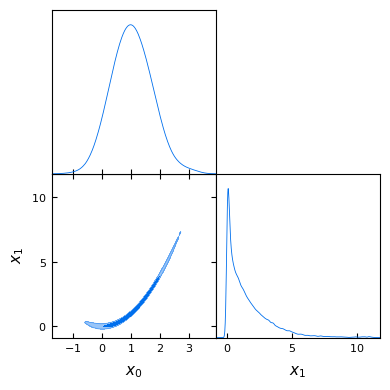

In [16]:
utils.plot_getdist(samples.reshape((-1, ndim)))